In [1]:
import tensorflow as tf
import numpy as np

import pandas as pd
import cv2
import os
import math
import scipy as sp
import PIL

# Tensorflow
from tensorflow.keras import models, layers, Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout, ZeroPadding2D

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB4, EfficientNetB6, ResNet50V2
#from keras_tuner.tuners import RandomSearch

import scikitplot as skplt
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt

In [2]:
# batch_size: 한번에 forward & Backword 하는 샘플의 수
batch_size = 12

# Training 수
epochs = 50

# Weight 조절 parameter
LearningRate = 1e-3 # 0.001
Decay = 1e-6

img_width = 224
img_height = 224

In [18]:
# 디렉토리 경로 설정 필요
CurrentDirectory = "../"

train_directory = CurrentDirectory + 'TRAIN/'
test_directory  = CurrentDirectory + 'TEST/'
model_directory = CurrentDirectory + 'MODEL/'
tensorboard_directory = CurrentDirectory + 'Tensorboard'

In [19]:
# Online-augmentation 적용 Generator
# 1. 이미지를 전부다 불러서 램 (메모리)에 올릴 수 없기 때문
# 2. 이미지는 Augmentation을 해주는게 좋아서

DATAGEN_TRAIN = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    featurewise_center=True,
    featurewise_std_normalization=True,
    data_format="channels_last",
    validation_split=0.10) # Train / Validation

In [20]:
TRAIN_GENERATOR = DATAGEN_TRAIN.flow_from_directory(
    train_directory,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode= "categorical",
    subset = "training")

VALID_GENERATOR = DATAGEN_TRAIN.flow_from_directory(
    train_directory,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode= "categorical",
    subset = "validation")

Found 567 images belonging to 3 classes.
Found 62 images belonging to 3 classes.


In [21]:
# Online-augmentation 적용 Generator
# 1. 이미지를 전부다 불러서 램 (메모리)에 올릴 수 없기 때문
# 2. 이미지는 Augmentation을 해주는게 좋아서

DATAGEN_TEST = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    data_format="channels_last")

In [22]:
TEST_GENERATOR = DATAGEN_TEST.flow_from_directory(
    test_directory,
    target_size = (img_width, img_height),
    batch_size = batch_size,
    class_mode= "categorical")

Found 106 images belonging to 3 classes.


In [23]:
TEST_GENERATOR.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [24]:
# Image는 0 ~ 1 사이 값이어야 plot이 가능함
item = TRAIN_GENERATOR.__getitem__(0)
print('item[0]:', item[0].shape)
print('item[1]:', item[1].shape)
print('batch_index:', TRAIN_GENERATOR.batch_index)

c:\ProgramData\Anaconda3\lib\site-packages\keras\preprocessing\image.py:1663: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\ProgramData\Anaconda3\lib\site-packages\keras\preprocessing\image.py:1671: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


item[0]: (12, 224, 224, 3)
item[1]: (12, 3)
batch_index: 0


In [25]:
item[0][0]

array([[[0.8061108 , 0.68804073, 0.72156596],
        [0.7976456 , 0.6703044 , 0.7090112 ],
        [0.8063782 , 0.6769253 , 0.7227814 ],
        ...,
        [0.7722735 , 0.64383066, 0.6844694 ],
        [0.76198435, 0.63585293, 0.6681772 ],
        [0.7527823 , 0.62430096, 0.6526643 ]],

       [[0.8072728 , 0.67614734, 0.7148592 ],
        [0.8002469 , 0.66154814, 0.6947949 ],
        [0.8007431 , 0.66752005, 0.707592  ],
        ...,
        [0.7693244 , 0.64643157, 0.66627145],
        [0.7727875 , 0.6512323 , 0.672611  ],
        [0.7599017 , 0.6418266 , 0.66342586]],

       [[0.7990194 , 0.68295825, 0.72930884],
        [0.7899616 , 0.6629703 , 0.6980377 ],
        [0.7952094 , 0.6715742 , 0.7091463 ],
        ...,
        [0.77382946, 0.6513119 , 0.6706648 ],
        [0.7742101 , 0.6523323 , 0.67194015],
        [0.7634577 , 0.64327896, 0.6628868 ]],

       ...,

       [[0.72156864, 0.6117647 , 0.6666667 ],
        [0.72156864, 0.6117647 , 0.6666667 ],
        [0.72156864, 0

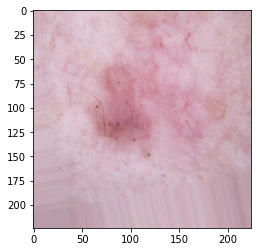

In [26]:
plt.imshow(item[0][0], interpolation='nearest')
plt.show()

In [27]:
# Image는 0 ~ 1 사이 값이어야 plot이 가능함
item = TEST_GENERATOR.__getitem__(0)
print('item[0]:', item[0].shape)
print('item[1]:', item[1].shape)
print('batch_index:', TRAIN_GENERATOR.batch_index)

item[0]: (12, 224, 224, 3)
item[1]: (12, 3)
batch_index: 0


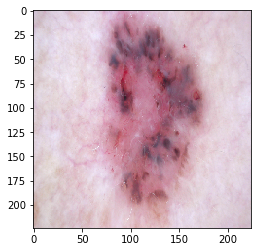

In [28]:
plt.imshow(item[0][0], interpolation='nearest')
plt.show()

In [29]:
# Image는 0 ~ 1 사이 값이어야 plot이 가능함
item = TRAIN_GENERATOR.__getitem__(0)
print('item[0]:', item[0].shape)
print('item[1]:', item[1].shape)
print('batch_index:', TRAIN_GENERATOR.batch_index)

item[0]: (12, 224, 224, 3)
item[1]: (12, 3)
batch_index: 0


In [30]:
EfficientNet = tf.keras.applications.EfficientNetB0(
    include_top=False, weights='imagenet',
    input_tensor=None, input_shape=(img_height, img_width,3),
    pooling=None)
x = GlobalAveragePooling2D()(EfficientNet.output)
predictions = Dense(3, activation='softmax')(x)
DeepLearning = Model(inputs=EfficientNet.input, outputs=predictions)

16705208/16705208 [==============================] - 0s 0us/step


In [31]:
DeepLearning.compile(optimizer=
         SGD(lr=LearningRate, decay=Decay, momentum=0.9, nesterov=True), 
         loss='categorical_crossentropy',
         metrics=['acc']
) # 나이를, MSE

c:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [32]:
# Call-back 함수

# CheckPoint: Epoch 마다 validation 성능을 검증하여, best performance 일 경우 저장
CP = ModelCheckpoint(filepath=model_directory+'VGG19-{epoch:03d}-{val_loss:.4f}-{val_acc:.4f}.hdf5',
            monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# 학습과정 진행사항 확인
TB = TensorBoard(log_dir=tensorboard_directory, write_graph=True, write_images=True)

# Learning Rate 줄여나가기
LR = ReduceLROnPlateau(monitor='val_loss',factor=0.8,patience=3, verbose=1, min_lr=1e-8)

CALLBACK = [CP, TB, LR]

In [33]:
########## Training Start
DeepLearning.fit(
        TRAIN_GENERATOR,
        # 데이터가 너무 클 경우 1-epoch을 못하는 경우
        # steps_per_epoch=TRAIN_GENERATOR.jjjjjjjjjjjjjjjjjjjjjjjjjjn / batch_size,
        
        epochs=15,
        callbacks=CALLBACK,
        shuffle=True, # Training에 패턴이 존재하면 overfit이 잘 되기 때문에, Shuffle 사용해야함. 단 test에는 절대 X
        validation_data=VALID_GENERATOR)
###########

Epoch 1/15
48/48 [==============================] - ETA: 0s - loss: 1.0230 - acc: 0.4691
Epoch 1: val_acc improved from -inf to 0.16129, saving model to ../MODEL\VGG19-001-1.2948-0.1613.hdf5
48/48 [==============================] - 176s 3s/step - loss: 1.0230 - acc: 0.4691 - val_loss: 1.2948 - val_acc: 0.1613 - lr: 0.0010
Epoch 2/15
48/48 [==============================] - ETA: 0s - loss: 0.8330 - acc: 0.5996
Epoch 2: val_acc did not improve from 0.16129
48/48 [==============================] - 143s 3s/step - loss: 0.8330 - acc: 0.5996 - val_loss: 1.1258 - val_acc: 0.1613 - lr: 0.0010
Epoch 3/15
43/48 [=========================>....] - ETA: 15s - loss: 0.7526 - acc: 0.6509

KeyboardInterrupt: 